In [1]:
import sys
print(sys.path)

['/home/hideo-t/work/py/crsq/crsq-heap/src', '/home/hideo-t/work/py/crsq/crsq-arithmetic/src', '/home/hideo-t/work/py/crsq/crsq-main/src', '/usr/lib/python310.zip', '/usr/lib/python3.10', '/usr/lib/python3.10/lib-dynload', '', '/home/hideo-t/work/py/crsq/.venv/lib/python3.10/site-packages']


INFO:crsq.blocks.wave_function:WaveFunctionRegisterSpec: dimension = 1
INFO:crsq.blocks.wave_function:WaveFunctionRegisterSpec: num_coordinate_bits = 6
INFO:crsq.blocks.wave_function:WaveFunctionRegisterSpec: space_length = 16.000000
INFO:crsq.blocks.wave_function:WaveFunctionRegisterSpec: num_electrons = 1
INFO:crsq.blocks.wave_function:WaveFunctionRegisterSpec: num_moving_nuclei = 0
INFO:crsq.blocks.wave_function:WaveFunctionRegisterSpec: num_stationary_nuclei = 0
INFO:crsq.blocks.wave_function:WaveFunctionRegisterSpec: use_spin = 0
INFO:crsq.blocks.wave_function:WaveFunctionRegisterSpec: num_orbital_index_bits = 0
INFO:crsq.blocks.discretization:DiscretizationSpec: delta_t = 0.001000
INFO:crsq.blocks.antisymmetrization:AntisymmetrizationSpec: method = 3
INFO:crsq.blocks.hamiltonian:HamiltonianSpec: max_particle_charge = 1.000000
INFO:crsq.blocks.hamiltonian:HamiltonianSpec: num_v_numerator_int_bits = 1
INFO:crsq.blocks.energy_initialization:EnergyConfigurationSpec: num_energy_config

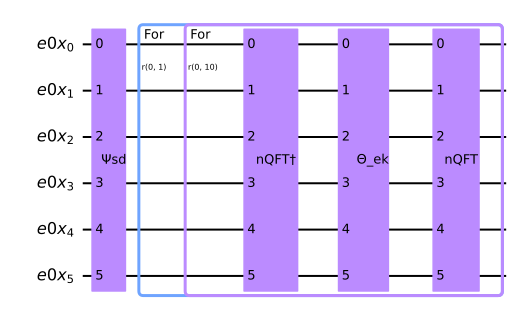

In [5]:
import math
import numpy as np

from crsq.blocks.antisymmetrization import AntisymmetrizationSpec
from crsq.blocks.discretization import DiscretizationSpec
from crsq.blocks.energy_initialization import EnergyConfigurationSpec
from crsq.blocks.hamiltonian import HamiltonianSpec
from crsq.blocks.time_evolution.spec import TimeEvolutionSpec
from crsq.blocks.wave_function import WaveFunctionRegisterSpec
from crsq.blocks.time_evolution.suzuki_trotter import SuzukiTrotterMethodBlock

import logging

logger = logging.getLogger('TEV')
logging.basicConfig(level=logging.INFO)


dim = 1
n1 = 6
L = 16 # 16 bohr
eta = 1 # num of electrons
Ln = 0 # moving nucleus
Ls = 0 # stationary nucleus
antisym_method = 3 # binary coded antisymmetrization method
wfr_spec = WaveFunctionRegisterSpec(dim, n1, L, eta, Ln, Ls)

delta_t = 0.001 # a.u.
disc_spec = DiscretizationSpec(delta_t)
asy_spec = AntisymmetrizationSpec(wfr_spec, antisym_method)
ham_spec = HamiltonianSpec(wfr_spec, nuclei_data = None)


def wave_packet(x, x0, k0, sigma):
    a = math.pow(math.pi*sigma*sigma, -0.25)
    b = 2*sigma*sigma
    gau_q = np.multiply(a, np.exp(-np.square(np.subtract(x, x0))/b)) * np.exp(1j*k0*np.subtract(x, x0))
    return gau_q

M = 2**n1
dq = L/M

x = np.linspace(0, L-dq, M)
x0 = 8
k = 4
sigma = 1
psi = wave_packet(x, x0, k, sigma)

ini_dims = [psi]
ini_electrons = [ini_dims]
ini_configs = [ini_electrons]
initial_electron_orbitals = ini_configs

initial_nucleus_orbitals = [[]]
ene_spec = EnergyConfigurationSpec([1], initial_electron_orbitals, initial_nucleus_orbitals)

num_nucl_it = 1 # number of nucleus iterations
num_elec_it = 10 # number of electron iterations
evo_spec = TimeEvolutionSpec(ham_spec, disc_spec, num_nucl_it, num_elec_it)

stm = SuzukiTrotterMethodBlock(evo_spec, ene_spec, asy_spec)

stm.circuit.draw(output='mpl')


In [6]:
from qiskit_aer import AerSimulator
from qiskit import transpile
import crsq.utils.statevector as svec

run_calculation=True
# run_calculation=False

dirname="output/time-evolution"
basename="wavepacket"

num_iters = [1, 10, 100, 500, 1000, 1500]

if run_calculation:
    backend = AerSimulator(device="CPU", precision="single")
    for num_elec_it in num_iters:
        num_nucl_it = 1 # number of nucleus iterations
        evo_spec = TimeEvolutionSpec(ham_spec, disc_spec, num_nucl_it, num_elec_it)
        stm = SuzukiTrotterMethodBlock(evo_spec, ene_spec, asy_spec)

        circ = stm.circuit
        circ.save_statevector()
        logger.info('transpile START')
        transpiled = transpile(circ, backend)
        logger.info('transpile END, run START')
        results = backend.run(transpiled).result()
        logger.info('run END')
        sv = results.get_statevector()
        time=num_elec_it*delta_t
        fname = f"{dirname}/{basename}.{n1}b.mu{x0}t{time}.csv"
        print("Saving to : " + fname)
        svec.save_to_file(fname, sv, eps=1e-12)

        elementary_gate_counts = transpiled.count_ops()
        print(elementary_gate_counts)

INFO:crsq.blocks.time_evolution.suzuki_trotter:SuzukiTrotterMethodBlock.build_circuit start
INFO:crsq.blocks.embed:call: AmplitudeEmbedGate
INFO:crsq.blocks.embed: AmplitudeEmbedGate: start == 0
INFO:crsq.blocks.embed: AmplitudeEmbedGate: start == 2
INFO:crsq.blocks.embed:start: invoke: [0,4]
INFO:qiskit.passmanager.base_tasks:Pass: UnrollCustomDefinitions - 0.01431 (ms)
INFO:qiskit.transpiler.passes.basis.basis_translator:Begin BasisTranslator from source basis {('ry', 1)} to target basis {'rx', 'z', 'cx', 'delay', 'measure', 'rz', 'reset', 'barrier', 'store', 'p', 'ry', 'x', 'snapshot', 'u'}.
INFO:qiskit.transpiler.passes.basis.basis_translator:Basis translation path search completed in 0.000s.
INFO:qiskit.transpiler.passes.basis.basis_translator:Basis translation paths composed in 0.000s.
INFO:qiskit.transpiler.passes.basis.basis_translator:Basis translation instructions replaced in 0.000s.
INFO:qiskit.passmanager.base_tasks:Pass: BasisTranslator - 2.91109 (ms)
INFO:qiskit.passmanag

Saving to : output/time-evolution/wavepacket.6b.mu8t0.001.csv
OrderedDict([('cx', 163084), ('u', 163080), ('ccx', 104672), ('cu', 30120), ('mcphase', 25264), ('cp', 17928), ('u3', 4), ('for_loop', 1), ('save_statevector', 1)])


INFO:qiskit.passmanager.base_tasks:Pass: UnrollCustomDefinitions - 0.02122 (ms)
INFO:qiskit.transpiler.passes.basis.basis_translator:Begin BasisTranslator from source basis {('ry', 1)} to target basis {'rx', 'z', 'cx', 'delay', 'measure', 'rz', 'reset', 'barrier', 'store', 'p', 'ry', 'x', 'snapshot', 'u'}.
INFO:qiskit.transpiler.passes.basis.basis_translator:Basis translation path search completed in 0.000s.
INFO:qiskit.transpiler.passes.basis.basis_translator:Basis translation paths composed in 0.000s.
INFO:qiskit.transpiler.passes.basis.basis_translator:Basis translation instructions replaced in 0.000s.
INFO:qiskit.passmanager.base_tasks:Pass: BasisTranslator - 1.72353 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: UnrollCustomDefinitions - 0.00858 (ms)
INFO:qiskit.transpiler.passes.basis.basis_translator:Begin BasisTranslator from source basis {('ry', 1)} to target basis {'rx', 'z', 'cx', 'delay', 'measure', 'rz', 'reset', 'barrier', 'store', 'p', 'ry', 'x', 'snapshot', 'u'}.
INFO:qi

Saving to : output/time-evolution/wavepacket.6b.mu8t0.01.csv
OrderedDict([('cx', 163084), ('u', 163080), ('ccx', 104672), ('cu', 30120), ('mcphase', 25264), ('cp', 17928), ('u3', 4), ('for_loop', 1), ('save_statevector', 1)])


INFO:qiskit.transpiler.passes.basis.basis_translator:Begin BasisTranslator from source basis {('ry', 1)} to target basis {'rx', 'z', 'cx', 'delay', 'measure', 'rz', 'reset', 'barrier', 'store', 'p', 'ry', 'x', 'snapshot', 'u'}.
INFO:qiskit.transpiler.passes.basis.basis_translator:Basis translation path search completed in 0.000s.
INFO:qiskit.transpiler.passes.basis.basis_translator:Basis translation paths composed in 0.000s.
INFO:qiskit.transpiler.passes.basis.basis_translator:Basis translation instructions replaced in 0.000s.
INFO:qiskit.passmanager.base_tasks:Pass: BasisTranslator - 1.70231 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: UnrollCustomDefinitions - 0.01383 (ms)
INFO:qiskit.transpiler.passes.basis.basis_translator:Begin BasisTranslator from source basis {('ry', 1)} to target basis {'rx', 'z', 'cx', 'delay', 'measure', 'rz', 'reset', 'barrier', 'store', 'p', 'ry', 'x', 'snapshot', 'u'}.
INFO:qiskit.transpiler.passes.basis.basis_translator:Basis translation path search comp

Saving to : output/time-evolution/wavepacket.6b.mu8t0.1.csv
OrderedDict([('cx', 163084), ('u', 163080), ('ccx', 104672), ('cu', 30120), ('mcphase', 25264), ('cp', 17928), ('u3', 4), ('for_loop', 1), ('save_statevector', 1)])


INFO:qiskit.transpiler.passes.basis.basis_translator:Basis translation path search completed in 0.000s.
INFO:qiskit.transpiler.passes.basis.basis_translator:Basis translation paths composed in 0.000s.
INFO:qiskit.transpiler.passes.basis.basis_translator:Basis translation instructions replaced in 0.000s.
INFO:qiskit.passmanager.base_tasks:Pass: BasisTranslator - 2.03443 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: UnrollCustomDefinitions - 0.00930 (ms)
INFO:qiskit.transpiler.passes.basis.basis_translator:Begin BasisTranslator from source basis {('ry', 1)} to target basis {'rx', 'z', 'cx', 'delay', 'measure', 'rz', 'reset', 'barrier', 'store', 'p', 'ry', 'x', 'snapshot', 'u'}.
INFO:qiskit.transpiler.passes.basis.basis_translator:Basis translation path search completed in 0.000s.
INFO:qiskit.transpiler.passes.basis.basis_translator:Basis translation paths composed in 0.000s.
INFO:qiskit.transpiler.passes.basis.basis_translator:Basis translation instructions replaced in 0.000s.
INFO:qiski

Saving to : output/time-evolution/wavepacket.6b.mu8t0.5.csv
OrderedDict([('cx', 163084), ('u', 163080), ('ccx', 104672), ('cu', 30120), ('mcphase', 25264), ('cp', 17928), ('u3', 4), ('for_loop', 1), ('save_statevector', 1)])


INFO:qiskit.transpiler.passes.basis.basis_translator:Basis translation path search completed in 0.000s.
INFO:qiskit.transpiler.passes.basis.basis_translator:Basis translation paths composed in 0.000s.
INFO:qiskit.transpiler.passes.basis.basis_translator:Basis translation instructions replaced in 0.000s.
INFO:qiskit.passmanager.base_tasks:Pass: BasisTranslator - 2.16699 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: UnrollCustomDefinitions - 0.01144 (ms)
INFO:qiskit.transpiler.passes.basis.basis_translator:Begin BasisTranslator from source basis {('ry', 1)} to target basis {'rx', 'z', 'cx', 'delay', 'measure', 'rz', 'reset', 'barrier', 'store', 'p', 'ry', 'x', 'snapshot', 'u'}.
INFO:qiskit.transpiler.passes.basis.basis_translator:Basis translation path search completed in 0.000s.
INFO:qiskit.transpiler.passes.basis.basis_translator:Basis translation paths composed in 0.000s.
INFO:qiskit.transpiler.passes.basis.basis_translator:Basis translation instructions replaced in 0.000s.
INFO:qiski

Saving to : output/time-evolution/wavepacket.6b.mu8t1.0.csv
OrderedDict([('cx', 163084), ('u', 163080), ('ccx', 104672), ('cu', 30120), ('mcphase', 25264), ('cp', 17928), ('u3', 4), ('for_loop', 1), ('save_statevector', 1)])


INFO:qiskit.transpiler.passes.basis.basis_translator:Begin BasisTranslator from source basis {('ry', 1)} to target basis {'rx', 'z', 'cx', 'delay', 'measure', 'rz', 'reset', 'barrier', 'store', 'p', 'ry', 'x', 'snapshot', 'u'}.
INFO:qiskit.transpiler.passes.basis.basis_translator:Basis translation path search completed in 0.000s.
INFO:qiskit.transpiler.passes.basis.basis_translator:Basis translation paths composed in 0.000s.
INFO:qiskit.transpiler.passes.basis.basis_translator:Basis translation instructions replaced in 0.000s.
INFO:qiskit.passmanager.base_tasks:Pass: BasisTranslator - 1.78981 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: UnrollCustomDefinitions - 0.01049 (ms)
INFO:qiskit.transpiler.passes.basis.basis_translator:Begin BasisTranslator from source basis {('ry', 1)} to target basis {'rx', 'z', 'cx', 'delay', 'measure', 'rz', 'reset', 'barrier', 'store', 'p', 'ry', 'x', 'snapshot', 'u'}.
INFO:qiskit.transpiler.passes.basis.basis_translator:Basis translation path search comp

Saving to : output/time-evolution/wavepacket.6b.mu8t1.5.csv
OrderedDict([('cx', 163084), ('u', 163080), ('ccx', 104672), ('cu', 30120), ('mcphase', 25264), ('cp', 17928), ('u3', 4), ('for_loop', 1), ('save_statevector', 1)])


Reading:  output/time-evolution/wavepacket.6b.mu8t0.001.csv
dists[26]+=(0.11613848805427551+0.0340179018676281j)
dists[31]+=(0.19637583196163177-0.30539554357528687j)
dists[32]+=(0.3750188648700714+0.00022995387553237379j)
dists[33]+=(0.1963740587234497+0.3062726855278015j)
dists[38]+=(0.11765735596418381-0.03401646018028259j)
norm(t=0.001) = 0.9985040310340496)
Reading:  output/time-evolution/wavepacket.6b.mu8t0.01.csv
dists[26]+=(0.11183550208806992+0.024909600615501404j)
dists[31]+=(0.1709023416042328-0.31631940603256226j)
dists[32]+=(0.3736313581466675-0.02840913087129593j)
dists[33]+=(0.22095203399658203+0.29279935359954834j)
dists[38]+=(0.12141808867454529-0.04410209506750107j)
norm(t=0.01) = 0.998501122144667)
Reading:  output/time-evolution/wavepacket.6b.mu8t0.1.csv
dists[32]+=(0.2325056791305542-0.25565415620803833j)
dists[33]+=(0.36517012119293213+0.05908048897981644j)
dists[34]+=(0.14872056245803833+0.3412051200866699j)
dists[39]+=(0.15165242552757263-0.005110489670187235j)


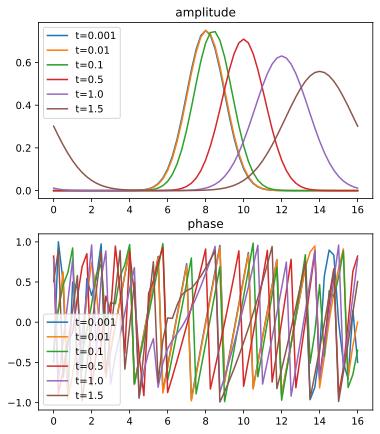

In [8]:
import crsq.utils.statevector as svec
import matplotlib.pyplot as plt
from matplotlib import cm
import numpy as np

#basename="flat"
#basename="sine"
basename = "wavepacket"

#times = reversed([0.0, 0.001, 0.01, 0.05, 0.1])
#times = [0.0, 0.001]


fig, ax = plt.subplots(2,1,figsize=(6,7))
#fig, ax = plt.subplots(2,1,figsize=(6,8), subplot_kw={"projection": "3d"}, layout='constrained')

ax1 = ax[0]
ax1.set_title("amplitude")
ax2 = ax[1]
ax2.set_title("phase")

g = 4

def wrap(x):
    return np.append(x, x[:1])

times = [delta_t * n_it for n_it in num_iters]

x = np.linspace(0, L, M+1)
for tm in times:
    fname = f"{dirname}/{basename}.{n1}b.mu{x0}t{tm}.csv"
    print("Reading: ", fname)
    qc = stm.circuit
    sv = svec.read_from_file(fname)
    #data = svec.extract_grouped_dist2(qc, sv, "n0x", "e0x", eps=1e-12)
    #y = wrap(data[g])
    data = svec.extract_dist(qc, sv, "e0x", eps=1e-12)
    #data = svec.extract_dist2d(qc, sv, "e0x", "e1x", eps=1e-12)
    # print(data)
    norm = np.linalg.norm(data)
    print(f"norm(t={tm}) = {norm})")
    y = wrap(data)
    # y = data
    a = np.abs(y) / math.sqrt(dq)
    th = np.angle(y)/math.pi
    ax1.plot(x,a, label=f"t={tm}")
    ax2.plot(x,th, label=f"t={tm}")
    #X = np.linspace(0, 7, 8)
    #Y = np.linspace(0, 7, 8)
    #X, Y = np.meshgrid(X,Y)
    #Z = data[X][Y]
    #surf1 = ax1.plot_surface(X,Y,a, cmap=cm.coolwarm)
    #surf2 = ax2.plot_surface(X,Y,th, cmap=cm.coolwarm)

ax1.legend()
ax2.legend()
fig.savefig("output/diagrams/tev.png")
